# An Analysis by an Atmospheric Scientist regarding Rain Forecast in Seattle

## Objective:

- The customer would like to know the likelihood of predicting whether it rains or not on a specific day ins Seattle by using MLAs. The input dataset (seattleWeather_1948-2017.csv) provides information on a few Meteorological variables in Seattle from 1948 to 2017.

- The input variables (predictors) are Date, PRCP, TMAX, and TMIN. The last three are numerical continuous variables.

- The outcome or dependent variable is RAIN (boolean).

- This is part 1: I will only use the available predictors (as they are) and will drop the ones that are not independent.

- In part 2, I will perform advanced feature engineering and will extract new variables based on the available predictors in order to improve the accuracy score.
----

Note that the other solutions to this problem, that I found on this website, did a terrible mistake and kept the variable PRCP (precipitation amount) to predict RAIN (binary rain: did it rain or not). This is cheating: your model would provide a perfect answer when the outcome is included among the predictors. When your model knows the amount of precipitation on a specific day, it can certainly say whether it rains or not. This motivated me to provide a better methodology.


### Importing important libraries:

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import os

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

### Reading the data:

In [21]:
met_df = pd.read_csv('/kaggle/input/did-it-rain-in-seattle-19482017/seattleWeather_1948-2017.csv')
print(met_df.head()); print(); print()
met_df.info()

         DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
DATE    25551 non-null object
PRCP    25548 non-null float64
TMAX    25551 non-null int64
TMIN    25551 non-null int64
RAIN    25548 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


The description and unit of each variable:
- DATE = the date of the observation
- PRCP = the amount of precipitation, in inches
- TMAX = the maximum temperature for that day, in degrees Fahrenheit
- TMIN = the minimum temperature for that day, in degrees Fahrenheit
- RAIN = TRUE if rain was observed on that day, FALSE if it was not

## Data Cleaing:

### Step 1: Correcting wrong values or outliers:

In [22]:
met_df.describe(include = 'all')

,DATE,PRCP,TMAX,TMIN,RAIN
count,25551,25548.000000,25551.000000,25551.000000,25548
unique,25551,NaN,NaN,NaN,2
top,1958-09-08,NaN,NaN,NaN,False
freq,1,NaN,NaN,NaN,14648
mean,NaN,0.106222,59.544206,44.514226,NaN
std,NaN,0.239031,12.772984,8.892836,NaN
min,NaN,0.000000,4.000000,0.000000,NaN
25%,NaN,0.000000,50.000000,38.000000,NaN
50%,NaN,0.000000,58.000000,45.000000,NaN
75%,NaN,0.100000,69.000000,52.000000,NaN


The data description makes sense, and the mean, min, and max values of each variable is reasonable meaning there should not be a mistake in the data (such as a very large temperature of 200 F).

### Step 2: Imputing missing values:

There are only three missing data points for each PRCP and RAIN. So, we use median for PRCP and mode for RAIN to fill in the gaps.

In [23]:
met_df.isna().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [24]:
P_median = met_df.PRCP.median()
R_mode   = met_df.RAIN.mode()[0]

met_df.PRCP.fillna(P_median, inplace = True)
met_df.RAIN.fillna(R_mode, inplace = True)

met_df.isna().sum()

DATE    0
PRCP    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

### Step 3: Converting boolean variable to dummy variable:
- We should change RAIN from True/False to 1/0.
- We then replace the new variable with the original one.

In [25]:
from sklearn.preprocessing import LabelEncoder
RAIN_encode = LabelEncoder().fit_transform(met_df.RAIN)
RAIN_encode

array([1, 1, 1, ..., 0, 0, 0])

In [26]:
met_df['RAIN'] = RAIN_encode

met_df.describe(include = 'all')

,DATE,PRCP,TMAX,TMIN,RAIN
count,25551,25551.000000,25551.000000,25551.000000,25551.000000
unique,25551,NaN,NaN,NaN,NaN
top,1958-09-08,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,0.106209,59.544206,44.514226,0.426598
std,NaN,0.239020,12.772984,8.892836,0.494592
min,NaN,0.000000,4.000000,0.000000,0.000000
25%,NaN,0.000000,50.000000,38.000000,0.000000
50%,NaN,0.000000,58.000000,45.000000,0.000000
75%,NaN,0.100000,69.000000,52.000000,1.000000


### Making sure all predictors are independent

### Insightful plots

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


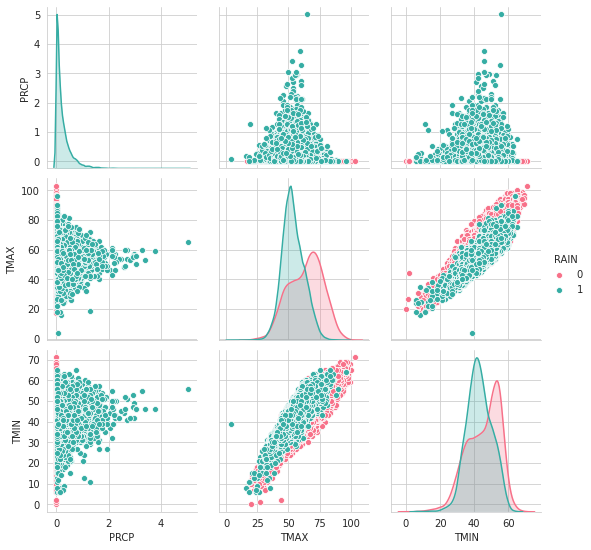

In [32]:
%matplotlib inline
rcParams['figure.figsize'] = 6, 5
sb.set_style('whitegrid')

sb.pairplot(met_df, palette = 'husl', hue = 'RAIN')
plt.show()

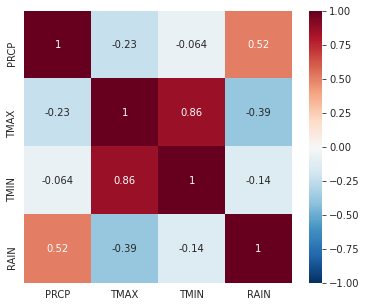

In [33]:
sb.heatmap(met_df.corr(), vmin=-1, vmax=1, annot=True, cmap = 'RdBu_r')
plt.show()

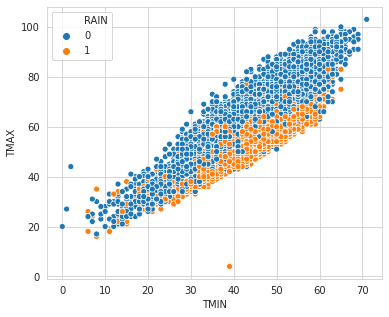

In [34]:
sb.scatterplot(x = 'TMIN', y ='TMAX', data = met_df, hue = 'RAIN')
plt.show()

- Ax expected, TMIN and TMAX are highliy correlated, so we drop TMIN that has lower correlation with RAIN.

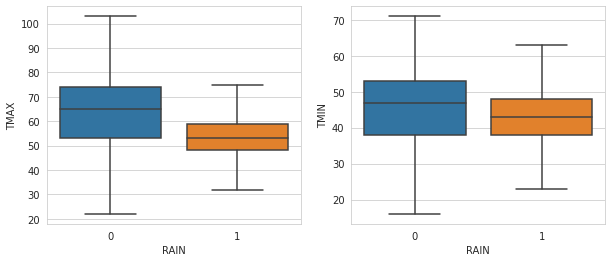

In [35]:
fig, axis = plt.subplots(1, 2,figsize=(10,4))
sb.boxplot(x = 'RAIN', y ='TMAX', data = met_df, ax = axis[0], showfliers = False)
sb.boxplot(x = 'RAIN', y ='TMIN', data = met_df, ax = axis[1], showfliers = False)
plt.show()

- Here, each TMAX and TMIN is grouped based on RAIN.
- Again, we see that TMAX is a better predictor of RAIN.

- We should also drop 'PRCP' variable: if we know the amount of precipitation on each day, we can certainly say whether it rains or not on that day.

In [36]:
met_df.drop(['TMIN', 'PRCP','DATE'], inplace = True, axis=1)
met_df.head()

,TMAX,RAIN
0,51,1
1,45,1
2,45,1
3,45,1
4,45,1


## Implementing MLAs:

### Spliting the data into test and train sets:


In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(met_df.drop('RAIN', axis=1),
                                                   met_df['RAIN'], test_size=0.2, random_state=10)                             


### Using a variety of MLAs to get the best results

- The outcome is binary, so we can use Logistic Regression, Decision Tree, or Naive Bayes. 
- We also use ensemble algorithms (such as Random Forest) to see if the score can be improved.

In [42]:
all_classifiers = {'Ada Boost': AdaBoostClassifier(),
                 'Random Forest': RandomForestClassifier(n_estimators=50, min_samples_leaf=1, min_samples_split=2, max_depth=4),
                 'Gaussian NB': GaussianNB(),
                 'Logistic Regression': LogisticRegression(solver='liblinear'),#fit_intercept=True,
                 'Decision Tree' : DecisionTreeClassifier(),
                  'SVC': SVC()} #probability = False 

In [39]:
ML_name = []
ML_accuracy = []
for Name,classifier in all_classifiers.items():
    classifier.fit(X_train,Y_train)
    Y_pred = classifier.predict(X_test)
    ML_accuracy.append(metrics.accuracy_score(Y_test,Y_pred)) 
    ML_name.append(Name) 

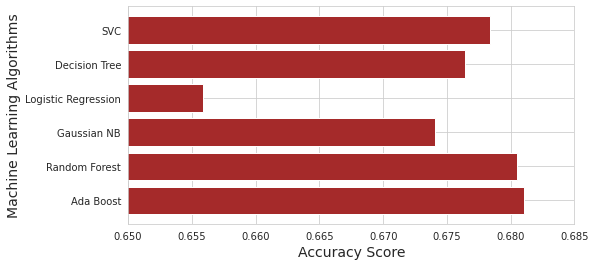

In [47]:
rcParams['figure.figsize'] = 8, 4
plt.barh(ML_name, ML_accuracy, color = 'brown')
plt.xlabel('Accuracy Score', fontsize = '14')
plt.ylabel('Machine Learning Algorithms', fontsize = '14')
plt.xlim([0.65, 0.685])
plt.show()

### Tuning models with hyper parameters:

- Let's see if we can improve a model performance by changing the hyper parameters.
- We are not going to test all the models, but just a few of them.


### Decision Tree:


In [49]:
criteri       = ['gini', 'entropy']
min_samp_lf   = [1, 2, 5, 10]
min_samp_splt = [2, 4, 8, 12]
maxim_depth   = [2, 4, 8, 12, None]

max_score = 0

for c in criteri:
    for ml in min_samp_lf:
        for ms in min_samp_splt:
            for md in maxim_depth:
                MLA = DecisionTreeClassifier(criterion=c, min_samples_leaf=ml, min_samples_split=ms, max_depth=md)
                MLA.fit(X_train,Y_train)
                Y_pred = MLA.predict(X_test)
                if metrics.accuracy_score(Y_test,Y_pred) > max_score:
                    max_score, c_best, l_best, s_best, d_best = metrics.accuracy_score(Y_test,Y_pred), c, ml, ms, md

print('maximum accuracy score, criterion, min_samples_leaf, min_samples_split, max_depth:')
print(max_score, c_best, l_best, s_best, d_best)

maximum accuracy score, criterion, min_samples_leaf, min_samples_split, max_depth:
0.6801017413422031 gini 1 2 4


### Ada Boost Classifier:

In [51]:
learning_R    = [1, 2, 3]
random_st     = [None, 20]
n_estimat     = [50, 100]

max_score = 0

for lr in learning_R:
    for rs in random_st:
        for ne in n_estimat:
            MLA = AdaBoostClassifier(random_state=rs, learning_rate=lr, n_estimators=ne)
            MLA.fit(X_train,Y_train)
            Y_pred = MLA.predict(X_test)
            if metrics.accuracy_score(Y_test,Y_pred) > max_score:
                max_score, r_best, l_best, n_best = metrics.accuracy_score(Y_test,Y_pred), rs, lr, ne

print('maximum accuracy score, random_state, learning_rate, n_estimators:')
print(max_score, r_best, l_best, n_best)

maximum accuracy score, random_state, learning_rate, n_estimators:
0.6810800234787713 None 1 50


### Model Validation:

See Part 2.

----

## Discussion:

- It seems that tuning hyper-parameters for various MLAs would give us an accuracy score of ~ 68.1%, meaning that our MLAs can predict the rain correctly in 68% of times for test datasets.

- This is better than the baseline: we should be able to predict rain by 50% accuracy only by tossing a coin. Moreover, there are 57% of instances of not rain and 43% instances of rain. So, if we always select not rain, we would get a score of 57%. So far, we improved the accuracy score by 11.1%.

- In part 2, we will utilize advanced feature engineering and subject-matter expertise to increase the accuracy score.

- Note that the limited number of predictors and the highly uncertain and non-linear nature of weather make it very difficult to increase the accuracy score to higher than ~85%. If it was possible, there would not be a need for super complex numerical weather prediction (NWP) models that use thousands of processes and mathematical models and are now very common for weather forecasts with high accuracy.

- I saw that other solutions claimed they reached an accuracy of higher than 90%. This is an artifact and mistake because they did not drop the 'PRCP' variable from the predictor list when using MLAs.
